In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

<h1> 1. Data Cleaning </h1>
<h2> 1.1 Import the Data </h2>

In [2]:
data = pd.read_csv("option_train.csv")

In [3]:
data.head(5)

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420.0,0.341270,0.03013,Under
1,0.125000,427.015526,465.0,0.166667,0.03126,Over
2,20.691244,427.762336,415.0,0.265873,0.03116,Under
3,1.035002,451.711658,460.0,0.063492,0.02972,Over
4,39.553020,446.718974,410.0,0.166667,0.02962,Under


<h2> 1.2 Data Exploring </h2>

In [4]:
data.describe()

,Value,S,K,tau,r
count,1678.000000,1679.000000,1678.000000,1679.000000,1680.000000
mean,15.068709,464.402535,438.241955,0.437519,0.030235
std,14.040023,973.652179,23.408989,7.057555,0.000557
min,0.125000,0.000000,375.000000,0.003968,0.029510
25%,2.255001,433.863864,420.000000,0.119048,0.029820
50%,11.190967,442.634081,440.000000,0.202381,0.030130
75%,25.747434,447.320414,455.000000,0.285714,0.030540
max,60.149367,40333.000000,500.000000,250.000000,0.031880


<h2> 1.2.1 Explore Extreme Value </h2>

<h4> 1.2.1.1 Value: current option value </h4>

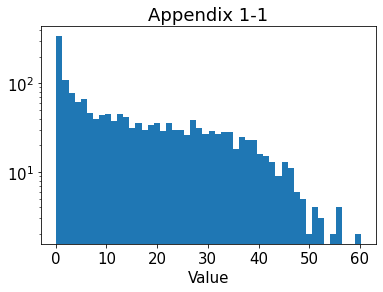

In [5]:
plt.rcParams.update({'figure.figsize':(6,4)})
plt.rcParams.update({'font.size':15})
plt.hist(data['Value'], bins = 50)
plt.yscale('log')
plt.xlabel('Value')
plt.title ('Appendix 1-1')
plt.show()

<h4> 1.2.1.2 S: current asset value </h4>

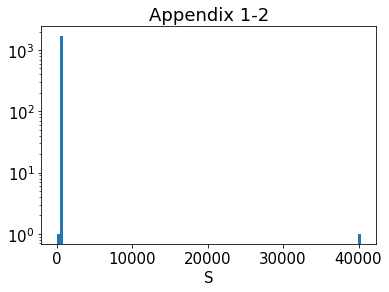

In [6]:
plt.hist(data['S'], bins = 100)
plt.yscale('log')
plt.xlabel('S')
plt.title ('Appendix 1-2')
plt.show()

In [7]:
data[data['S'] > 5000]

,Value,S,K,tau,r,BS
47,11.451273,40333.0,425.0,0.043651,0.03147,Under


When the asset value is extremely high, we examine the observation carefully and think the difference between asset value and strike price is extremely high and the value of option doesn't match the difference. Therefore we treat the observation as an outlier.

In [8]:
data.drop(labels = data[data['S'] > 5000].index, axis = 0, inplace = True)

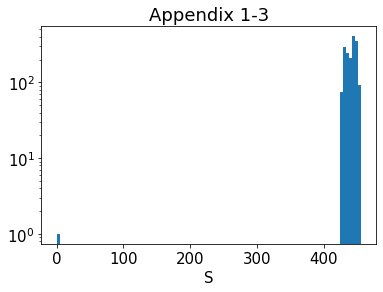

In [9]:
plt.hist(data['S'], bins = 100)
plt.yscale('log')
plt.xlabel('S')
plt.title ('Appendix 1-3')
plt.show()

In [10]:
data[data['S'] == 0]

,Value,S,K,tau,r,BS
879,4.125,0.0,455.0,0.170635,0.03003,Over


In [11]:
data.drop(labels = data[data['S'] == 0].index, axis = 0, inplace = True)

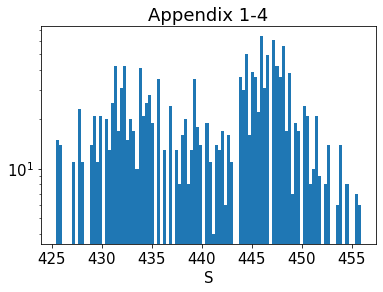

In [12]:
plt.hist(data['S'], bins = 100)
plt.yscale('log')
plt.xlabel('S')
plt.title ('Appendix 1-4')
plt.show()

<h4> 1.2.1.3 K: strike price of option</h4>

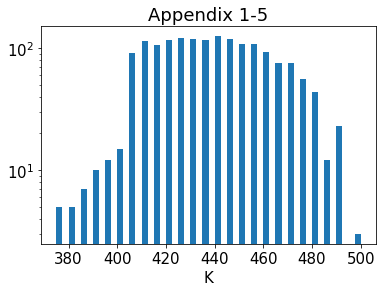

In [13]:
plt.hist(data['K'], bins = 50)
plt.yscale('log')
plt.xlabel('K')
plt.title ('Appendix 1-5')
plt.show()

<h4> 1.2.1.4 r: annual interest rate</h4>

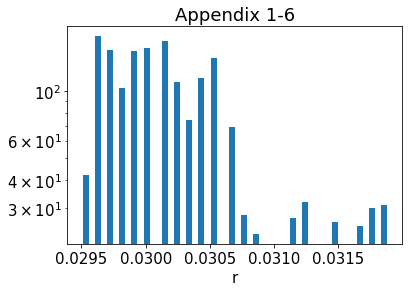

In [14]:
plt.hist(data['r'], bins = 50)
plt.yscale('log')
plt.xlabel('r')
plt.title ('Appendix 1-6')
plt.show()

<h4> 1.2.1.5 tau: time to maturity  </h4>

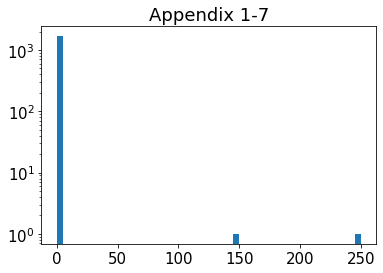

In [15]:
plt.hist(data['tau'], bins = 50)
plt.yscale('log')
plt.title ('Appendix 1-7')
plt.show()

In [16]:
data[data['tau'] > 1]

,Value,S,K,tau,r,BS
12,2.315001,448.688109,470.0,250.0,0.03013,Over
33,2.565000,445.042240,455.0,146.0,0.03003,Over


We notcie that time to maturity of 2 observations extremely exceeds 1 year (250 years and 146 years respectively). In reality, time to maturity of options usually won't exceed 1 year. Therefore, we identify these two observations as outliers and remove them from the dataset.

In [17]:
data.drop(labels = data[data['tau'] > 1].index, axis = 0, inplace = True)

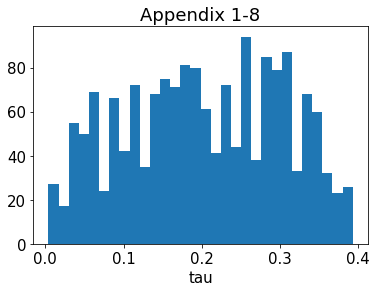

In [18]:
plt.hist(data['tau'], bins =30)
plt.xlabel("tau")
plt.title ('Appendix 1-8')
plt.show()

<h4> 1.2.1.6 BS: Black-Scholes  </h4>

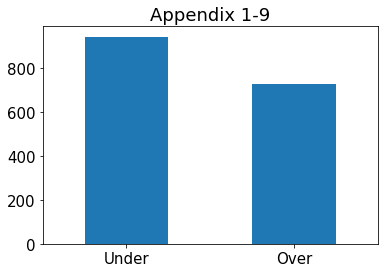

In [19]:
data['BS'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.title ('Appendix 1-9')
plt.show()

<h4> 1.2.1.7 Boxplot of Each Variable  </h4>

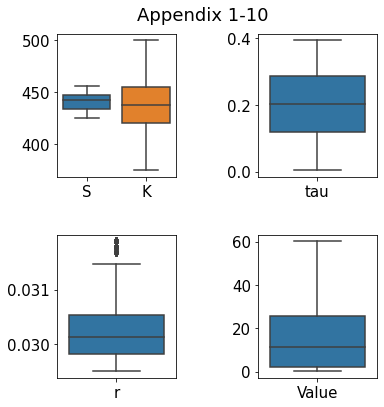

In [20]:
fig, axs = plt.subplots(2,2, figsize = (6,6))
fig.tight_layout(pad = 2)
sns.boxplot(ax = axs[0,0], data = data[['S', 'K']])
sns.boxplot(ax = axs[0,1], data = data[['tau']])
sns.boxplot(ax = axs[1,0], data = data[['r']])
sns.boxplot(ax = axs[1,1], data = data[['Value']])
fig.suptitle ('Appendix 1-10')
plt.show()

<h3> 1.2.2 Remove Missing Value </h3>

In [21]:
np.sum(data.isnull())

Value    2
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

In [22]:
data.drop(labels = data[data['Value'].isnull()].index, axis = 0, inplace = True)
data.drop(labels = data[data['S'].isnull()].index, axis = 0, inplace = True)
data.drop(labels = data[data['K'].isnull()].index, axis = 0, inplace = True)
data.drop(labels = data[data['tau'].isnull()].index, axis = 0, inplace = True)

<h3> 1.2.3 Encoding Categorical Variable </h3>

Encoding BS into categorical variable where 1 = Over, 0 = Under

In [23]:
mapping = {'Under': 0, 'Over': 1}
data['BS'] = data['BS'].map(mapping)

In [24]:
data.set_index(pd.Series([x for x in range(data.shape[0])]), inplace = True)

<h1> 2. Feature Engineering </h1>

<h2> 2.1 Non-Linear and Interaction Variables </h2>

$\frac{S}{K}$,  $log(\frac{S}{K})$, $r*tau$, $(\frac{S}{K})^2$, $(1 + r)*tau$, $\sqrt{tau}$

In [25]:
data['S/K'] = data['S']/data['K']
data['log(S/K)'] = np.log(data['S/K'])
data['(S/K)^2'] = data['S/K']**2
data['r*tau'] = data['r']*data['tau']
data['(1+r)*tau'] = data['tau'] + data['r*tau']
data['(tau)^1/2'] = data['tau']**2

<h2> 2.2 Future Value </h2>

(S-K), (S-K)/(r*tau), (S-K)/tau, 1/(1 + r/tau), K/discount rate

In [26]:
data['(S-K)'] = data['S'] - data['K']
data['(S-K)*(r*tau)'] = data['(S-K)']*data['r*tau']
data['discount rate'] = 1 + data['r*tau']
data['K*discount rate'] = data['K']*data['discount rate']
data['(S-K)*discount rate'] = data['(S-K)']*data['discount rate']

<h1> 3. Model Exploration - With Initial Variables </h1>

<h2> 3.1 For Value (C) </h2>
<h3> 3.1.1 Linear Regression </h3>

In [27]:
y = data[['Value', 'BS']]
y_value = data['Value']
y_BS = data['BS']
X = data.drop(['Value', 'BS','discount rate'], axis = 1)
kfolds = KFold(n_splits = 10, random_state = 1, shuffle = True)

value_score = pd.DataFrame(columns = ['Training CV', 'Testing CV', 
                                      'Training Validation Set Approach', 'Testing Validation Set Approach'])
value_compare = pd.DataFrame(columns = ['model','Training', 'Testing'])

In [28]:
# Use cross validation to get Mean out of sample R-squared
cv_score_train = []
cv_score_test = []
original_var = ['K', 'S', 'tau', 'r']
for train_index, test_index in kfolds.split(X, y_value):
    X1 = X.iloc[train_index][original_var]
    X1 = sm.add_constant(X1)
    y_train = y_value.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    X_test = sm.add_constant(X_test)
    y_test = y_value.iloc[test_index]
    
    # Train the model
    model = sm.OLS(y_train, X1)
    regression = model.fit()
    
    # Return the score
    r2_train = regression.rsquared
    TSS_test = ((y_test - y_test.mean())**2).sum()
    RSS_test = ((regression.predict(X_test) - y_test)**2).sum()
    r2_test = (TSS_test - RSS_test)/TSS_test

    cv_score_train.append(r2_train)
    cv_score_test.append(r2_test)

In [29]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X, y_value, test_size=0.2,random_state=5)

X1 = sm.add_constant(X_train[original_var])
X2 = sm.add_constant(X_test[original_var])

# Train the model
model = sm.OLS(y_train, X1)
regression = model.fit()

# Return the score
r2_train = regression.rsquared
TSS_test = ((y_test - y_test.mean())**2).sum()
RSS_test = ((regression.predict(X2) - y_test)**2).sum()
r2_test = (TSS_test - RSS_test)/TSS_test

In [30]:
# store score for each model
value_score.loc['Linear Regression'] = [np.mean(cv_score_train), np.mean(cv_score_test), r2_train, r2_test]
df = pd.DataFrame({'model': ['Linear Regression']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.2 Decision Tree Regression </h3>

In [31]:
def tree_cost_complexity_pruning(X, y_value):
    clf_tree = DecisionTreeRegressor(random_state=0)
    path = clf_tree.cost_complexity_pruning_path(X, y_value)
    ccp_alphas = path.ccp_alphas
    score = []
    ccp_alphas = ccp_alphas[ccp_alphas >=0]
    for ccp_alpha in ccp_alphas:
        score_for_alpha = []
        for train_index, test_index in kfolds.split(X, y_value):
            X_train = X.iloc[train_index][original_var]
            y_train = y_value.iloc[train_index]
            X_test = X.iloc[test_index][original_var]
            y_test = y_value.iloc[test_index]
            
            clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
            clf.fit(X_train, y_train)

            TSS_test = ((y_test - y_test.mean())**2).sum()
            RSS_test = ((clf.predict(X_test) - y_test)**2).sum()
            r2_test = (TSS_test - RSS_test)/TSS_test
            score_for_alpha.append(r2_test)
        score.append(sum(score_for_alpha)/len(score_for_alpha))
        
    alpha_cv = ccp_alphas[np.argmax(score)]
    return alpha_cv

In [32]:
def cv(var,model):
    cv_score_train = []
    cv_score_test = []
    model_name = model
    if model == 'Random Forest':
        model = RandomForestRegressor(random_state=9, n_estimators =100, max_depth = 100, min_samples_split=10,
                                      min_samples_leaf=10)
    if model == 'Decision Tree':
        model = DecisionTreeRegressor(random_state=9, max_depth = 100, min_samples_split=30,min_samples_leaf=20, 
                                      ccp_alpha = alpha_cv)
    elif model == 'Linear':
        model = LinearRegression()
    elif model == 'LGBM':
        model = lgb.LGBMRegressor(random_state = 5, num_leaves=20,n_estimators=100, max_depth = 50)
    elif model == 'NN':
        model = MLPRegressor(random_state = 5,hidden_layer_sizes=(18,18,18), activation = 'relu', solver = 'adam',
                             learning_rate= 'constant',
                          learning_rate_init = 0.01)
    elif model == 'KNeighbors':
        model = KNeighborsRegressor(n_neighbors=3)
    elif model == 'XGBoost':
        model = xgb.XGBRegressor(random_state = 5,max_depth=25, n_estimators=30)
    elif model == 'CatBoost':
        model = CatBoostRegressor(random_state = 5,verbose=0, max_depth=8, iterations=200, learning_rate = 0.1)
    for train_index, test_index in kfolds.split(X, y_value):
        X_train = X.iloc[train_index][list(var)]
        y_train = y_value.iloc[train_index]
        X_test = X.iloc[test_index][list(var)]
        y_test = y_value.iloc[test_index]
        # Train the model
        regression = model.fit(X_train, y_train)
        # Return the score
        # rsquared for train data
        TSS_train = ((y_train - y_train.mean())**2).sum()
        RSS_train = ((regression.predict(X_train) - y_train)**2).sum()
        r2_train = (TSS_train - RSS_train)/TSS_train
        # rsquared for test data
        TSS_test = ((y_test - y_test.mean())**2).sum()
        RSS_test = ((regression.predict(X_test) - y_test)**2).sum()
        r2_test = (TSS_test - RSS_test)/TSS_test

        cv_score_train.append(r2_train)
        cv_score_test.append(r2_test)
    
    value_score.loc[model_name,['Training CV', 'Testing CV']] = [np.mean(cv_score_train), np.mean(cv_score_test)]
    return {"model": model, "r2_train": cv_score_train, "r2_test": cv_score_test, "variable": var}

In [33]:
def validation_set_approach(var, model):
    # Use Train Test Split to test the model performance
    X_train, X_test, y_train, y_test = train_test_split(X[var], y_value, test_size=0.2,random_state=5)
    model_name = model
    if model == 'Random Forest':
        model = RandomForestRegressor(random_state=9, n_estimators =100, max_depth = 100, min_samples_split=10,
                                      min_samples_leaf=10)
    if model == 'Decision Tree':
        model = DecisionTreeRegressor(random_state=9, max_depth = 100, min_samples_split=30,min_samples_leaf=20, 
                                      ccp_alpha = alpha_cv)   
    elif model == 'Linear':
        model = LinearRegression()
    elif model == 'LGBM':
        model = lgb.LGBMRegressor(random_state = 5, num_leaves=20,n_estimators=100, max_depth = 50)
    elif model == 'NN':
        model = MLPRegressor(random_state = 5,hidden_layer_sizes=(18,18,18), activation = 'relu', solver = 'adam', 
                             learning_rate= 'constant',
                          learning_rate_init = 0.01)
    elif model == 'KNeighbors':
        model = KNeighborsRegressor(n_neighbors=3)
    elif model == 'XGBoost':
        model = xgb.XGBRegressor(random_state = 5,max_depth=25, n_estimators=30)
    elif model == 'CatBoost':
        model = CatBoostRegressor(random_state = 5,verbose=0, max_depth=8, iterations=200, learning_rate = 0.1)
    # Train the model
    regression = model.fit(X_train, y_train)
    # Return the score
    # rsquared for train data
    TSS_train = ((y_train - y_train.mean())**2).sum()
    RSS_train = ((regression.predict(X_train) - y_train)**2).sum()
    r2_train = (TSS_train - RSS_train)/TSS_train
    # rsquared for test data
    TSS_test = ((y_test - y_test.mean())**2).sum()
    RSS_test = ((regression.predict(X_test) - y_test)**2).sum()
    r2_test = (TSS_test - RSS_test)/TSS_test
    value_score.loc[model_name,['Training Validation Set Approach', 'Testing Validation Set Approach']] /=
        [r2_train, r2_test]

In [34]:
original_var = ['K', 'S', 'tau', 'r']
alpha_cv = tree_cost_complexity_pruning(X[original_var],y_value)
result = cv(original_var, model = 'Decision Tree')
validation_set_approach(original_var, 'Decision Tree')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [35]:
# store score for each model
df = pd.DataFrame({'model': ['Decision Tree']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.3 Random Forest Regression </h3>

In [36]:
result = cv(original_var, model = 'Random Forest')
validation_set_approach(original_var, 'Random Forest')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [37]:
# store score for each model
df = pd.DataFrame({'model': ['Random Forest']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.4 LGBM Regression </h3>

In [38]:
result = cv(original_var, model = 'LGBM')
validation_set_approach(original_var, 'LGBM')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [39]:
# store score for each model
df = pd.DataFrame({'model': ['LGBM']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.5 Nerual Network Regression </h3>

In [40]:
result = cv(original_var, model = 'NN')
validation_set_approach(original_var, 'NN')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [41]:
# store score for each model
df = pd.DataFrame({'model': ['Neural Network']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.6 KNeighbors Regression </h3>

In [42]:
result = cv(original_var, model = 'KNeighbors')
validation_set_approach(original_var, 'KNeighbors')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [43]:
# store score for each model
df = pd.DataFrame({'model': ['KNeighbors']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.7 XGBoost Regression </h3>

In [44]:
result = cv(original_var, model = 'XGBoost')
validation_set_approach(original_var, 'XGBoost')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [45]:
# store score for each model
df = pd.DataFrame({'model': ['XGBoost']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

<h3> 3.1.8 CatBoost Regression </h3>


In [46]:
result = cv(original_var, model = 'CatBoost')
validation_set_approach(original_var, 'CatBoost')
cv_score_train = result['r2_train']
cv_score_test = result['r2_test']

In [47]:
# store score for each model
df = pd.DataFrame({'model': ['CatBoost']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

In [48]:
value_score

,Training CV,Testing CV,Training Validation Set Approach,Testing Validation Set Approach
Linear Regression,0.911910,0.910002,0.912325,0.908975
Decision Tree,0.975635,0.969149,0.974508,0.962396
Random Forest,0.989055,0.984696,0.987830,0.982893
LGBM,0.997700,0.995823,0.997175,0.996120
NN,0.977895,0.977544,0.972457,0.969199
KNeighbors,0.987691,0.973050,0.987685,0.966178
XGBoost,0.999999,0.997885,0.999999,0.997799
CatBoost,0.999615,0.998490,0.999629,0.998905


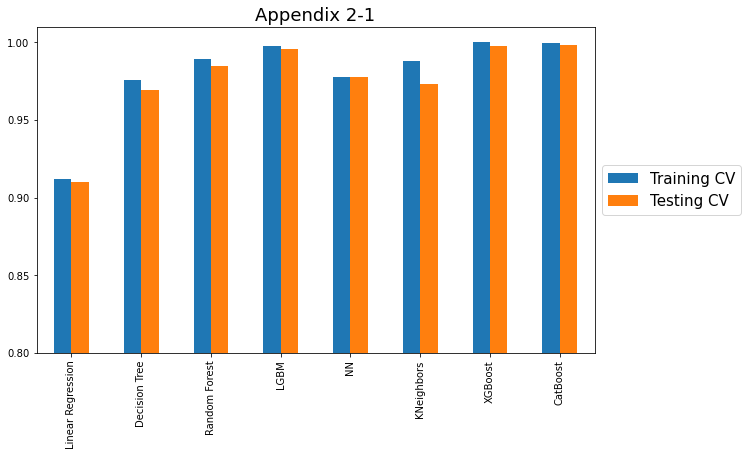

In [49]:
value_score[['Training CV', 'Testing CV']].plot(kind = 'bar', figsize = (10,6), fontsize = 10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.8, 1.01)
plt.yticks([0.8, 0.85, 0.9, 0.95,1.0])
plt.title ('Appendix 2-1')
plt.show()

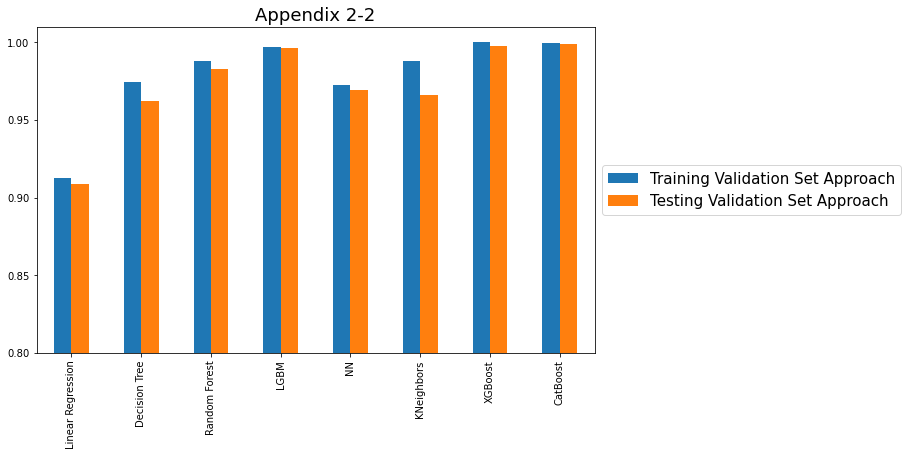

In [50]:
value_score[['Training Validation Set Approach', 'Testing Validation Set Approach']].plot(kind = 'bar', 
                                                                        figsize = (10,6), fontsize = 10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.8, 1.01)
plt.yticks([0.8, 0.85, 0.9, 0.95,1.0])
plt.title ('Appendix 2-2')
plt.show()

In [51]:
value_compare = value_compare.melt(id_vars = ['model'])

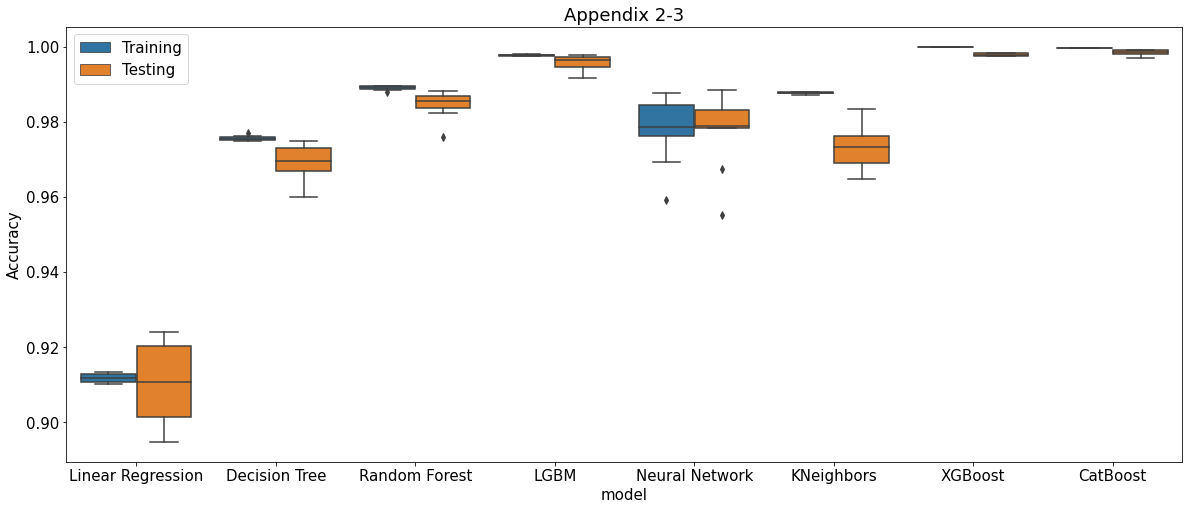

In [52]:
plt.figure(figsize = (20,8))
sns.boxplot(x='model',y='value',hue='variable', data=value_compare)
plt.ylabel('Accuracy')
plt.legend(title = '')
plt.title ('Appendix 2-3')
plt.show()

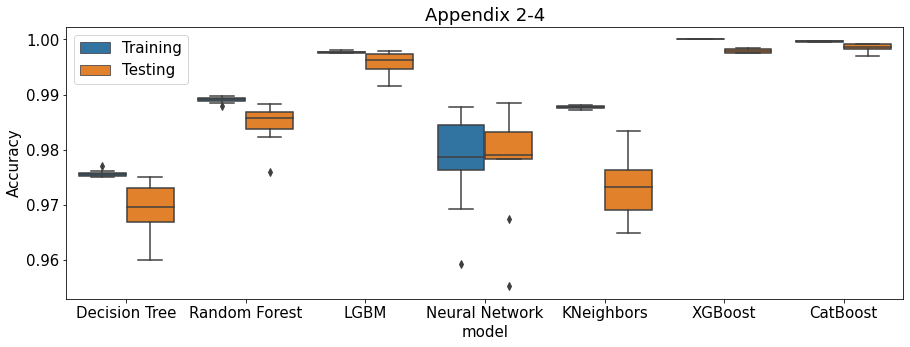

In [53]:
plt.figure(figsize = (15,5))
sns.boxplot(x='model',y='value',hue='variable', data = value_compare[value_compare['model'] != 'Linear Regression'])
plt.ylabel('Accuracy')
plt.legend(title = '')
plt.title ('Appendix 2-4')
plt.show()

<h2> 3.2 For BS </h2>
<h3> 3.2.1 Logistic Regression </h3>

In [54]:
kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
BS_score = pd.DataFrame(columns = ['Training CV', 'Testing CV', 
                                      'Training Validation Set Approach', 'Testing Validation Set Approach'])
BS_compare = pd.DataFrame(columns = ['model','Training', 'Testing'])

In [55]:
cv_classification_score_train = []
cv_classification_score_test = []

for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    
    # Fit the model
    model = LogisticRegression(penalty='none', max_iter=10000).fit(X1,y_train)
    
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [56]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=5)

# Train the model
model = LogisticRegression(penalty='none', max_iter=10000)
model = model.fit(X_train, y_train)

# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)

# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [57]:
# store accuracy score for each model
BS_score.loc['Logistic Regression'] = [np.mean(cv_classification_score_train), 
                                       np.mean(cv_classification_score_test),score_train, score_test]
df = pd.DataFrame({'model': ['Logistic Regression']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.2 Decision Tree Classification </h3>

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
def tree_cost_complexity_pruning(X, y_BS):
    clf_tree = DecisionTreeClassifier(random_state=0)
    path = clf_tree.cost_complexity_pruning_path(X, y_BS)
    ccp_alphas = path.ccp_alphas
    accuracies = []
    ccp_alphas = ccp_alphas[ccp_alphas >=0]
    for ccp_alpha in ccp_alphas:
        score_for_alpha = []
        for train_index, test_index in kfolds.split(X, y_BS):
            clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
            clf.fit(X.iloc[train_index], y_BS.iloc[train_index])
            y_pred = clf.predict(X.iloc[test_index])
            score = accuracy_score(y_pred, y_BS.iloc[test_index])
            score_for_alpha.append(score)
        accuracies.append(sum(score_for_alpha)/len(score_for_alpha))
    alpha_cv = ccp_alphas[np.argmax(accuracies)]
    return alpha_cv

In [60]:
cv_classification_score_train = []
cv_classification_score_test = []
alpha_cv = tree_cost_complexity_pruning(X,y_BS)
for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    # Fit the model
    model = DecisionTreeClassifier(random_state=8, max_depth = 80, min_samples_split=10,min_samples_leaf=20,
                                   ccp_alpha = alpha_cv)
    model.fit(X1,y_train)
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [61]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)
# Train the model
model = DecisionTreeClassifier(random_state=8, max_depth = 80, min_samples_split=10,min_samples_leaf=20, 
                               ccp_alpha = alpha_cv)
model = model.fit(X_train, y_train)
# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)
# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [62]:
BS_score.loc['Decision Tree'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['Decision Tree']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.3 Random Forest Classification </h3>

In [63]:
cv_classification_score_train = []
cv_classification_score_test = []
for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    
    # Fit the model
    model = RandomForestClassifier(random_state=3, n_estimators =100, max_depth = 100, min_samples_split= 2,
                                   min_samples_leaf=2).fit(X1,y_train)
    
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [64]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)
# Train the model
model = RandomForestClassifier(random_state=3, n_estimators =100, max_depth = 100, min_samples_split= 2, 
                               min_samples_leaf=2)
model = model.fit(X_train, y_train)
# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)
# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [65]:
BS_score.loc['Random Forest'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['Random Forest']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.4 LGBM Classification </h3>

In [66]:
cv_classification_score_train = []
cv_classification_score_test = []

for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    
    # Fit the model
    model = lgb.LGBMClassifier(num_leaves=25,n_estimators=30, max_depth = 30).fit(X1,y_train)
    
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [67]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)

# Train the model
model = lgb.LGBMClassifier(num_leaves=25,n_estimators=30, max_depth = 30)
model = model.fit(X_train, y_train)

# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)

# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [68]:
BS_score.loc['LGBM'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['LGBM']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.5 Neural Network Classification </h3>

In [69]:
cv_classification_score_train = []
cv_classification_score_test = []
for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    # Fit the model
    model = MLPClassifier(random_state = 5, hidden_layer_sizes=(15,15,15,15,15), activation = 'relu', 
                          solver = 'adam', learning_rate= 'adaptive',
                          learning_rate_init = 0.01).fit(X1,y_train)
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [70]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)
# Train the model
model = MLPClassifier(random_state = 5, hidden_layer_sizes=(15,15,15,15,15), activation = 'relu', 
                      solver = 'adam', learning_rate= 'adaptive',
                          learning_rate_init = 0.01).fit(X_train, y_train)
# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)

# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [71]:
BS_score.loc['Neural Network'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['Neural Network']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.6 KNeighbors Classification </h3>

In [72]:
cv_classification_score_train = []
cv_classification_score_test = []

for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    
    # Fit the model
    model = KNeighborsClassifier(n_neighbors = 8).fit(X1,y_train)
    
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [73]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)

# Train the model
model = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train)

# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)

# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [74]:
BS_score.loc['KNeighbors'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['KNeighbors']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.7 XGBoost Classification </h3>

In [75]:
cv_classification_score_train = []
cv_classification_score_test = []

for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    # Fit the model
    model = xgb.XGBClassifier(random_state = 5, max_depth=10, n_estimators=5).fit(X1,y_train)
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [76]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)
# Train the model
model = xgb.XGBClassifier(random_state = 4, max_depth=10, n_estimators=5).fit(X_train, y_train
# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)
# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [77]:
BS_score.loc['XGBoost'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['XGBoost']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

<h3> 3.2.8 Catboost Classification </h3>

In [78]:
cv_classification_score_train = []
cv_classification_score_test = []
for train_index, test_index in kfolds.split(X, y_BS):
    X1 = X.iloc[train_index][original_var]
    y_train = y_BS.iloc[train_index]
    X_test = X.iloc[test_index][original_var]
    y_test = y_BS.iloc[test_index]
    # Fit the model
    model = CatBoostClassifier(random_state = 5, verbose=0, max_depth=5, iterations=100, 
                               learning_rate = 0.1).fit(X1,y_train)
    # Store the score
    cv_classification_score_train.append(model.score(X1, y_train))
    cv_classification_score_test.append(model.score(X_test[original_var], y_test))

In [79]:
# Use Train Test Split to test the model performance
X_train, X_test, y_train, y_test = train_test_split(X[original_var], y_BS, test_size=0.2,random_state=4)
# Train the model
model = CatBoostClassifier(random_state = 5, verbose=0, max_depth=5, iterations=100, 
                           learning_rate = 0.1).fit(X_train, y_train)
# Return the score
# accuracy score for train data
score_train = accuracy_score(model.predict(X_train), y_train)
# accuracy score for test data
score_test = accuracy_score(model.predict(X_test), y_test)

In [80]:
BS_score.loc['CatBoost'] = [np.mean(cv_classification_score_train), np.mean(cv_classification_score_test), 
                                          score_train, score_test]
df = pd.DataFrame({'model': ['CatBoost']*10, 
              'Training': cv_classification_score_train, 
              'Testing': cv_classification_score_test})
BS_compare = pd.concat([BS_compare, df])

In [81]:
# store score for each model
value_score.loc['CatBoost'] = [np.mean(cv_score_train), np.mean(cv_score_test), r2_train, r2_test]
df = pd.DataFrame({'model': ['CatBoost']*10, 
              'Training': cv_score_train, 
              'Testing': cv_score_test})
value_compare = pd.concat([value_compare, df])

In [82]:
BS_score

,Training CV,Testing CV,Training Validation Set Approach,Testing Validation Set Approach
Logistic Regression,0.911071,0.910340,0.914798,0.901493
Decision Tree,0.925218,0.912753,0.928251,0.904478
Random Forest,0.987381,0.931890,0.986547,0.928358
LGBM,0.967723,0.934870,0.965620,0.928358
Neural Network,0.901109,0.899604,0.905082,0.901493
KNeighbors,0.925882,0.906166,0.922272,0.910448
XGBoost,0.975958,0.930101,0.976084,0.931343
CatBoost,0.945142,0.933084,0.943199,0.934328


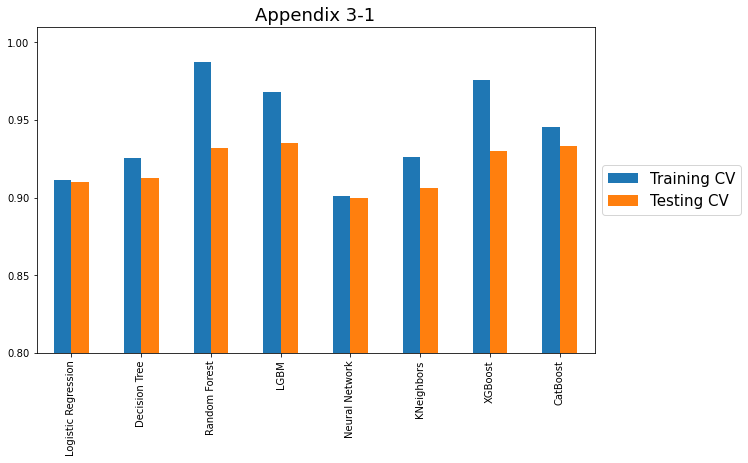

In [83]:
BS_score[['Training CV', 'Testing CV']].plot(kind = 'bar', figsize = (10,6), fontsize = 10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.8, 1.01)
plt.yticks([0.8, 0.85, 0.9, 0.95,1.0])
plt.title ('Appendix 3-1')
plt.show()

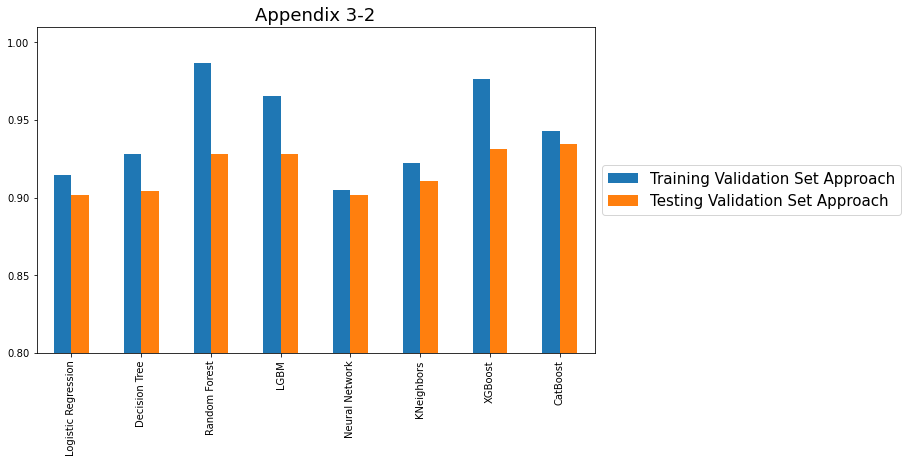

In [84]:
BS_score[['Training Validation Set Approach', 'Testing Validation Set Approach']].plot(
    kind = 'bar', figsize = (10,6), fontsize = 10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.8, 1.01)
plt.yticks([0.8, 0.85, 0.9, 0.95,1.0])
plt.title ('Appendix 3-2')
plt.show()

In [85]:
BS_compare = BS_compare.melt(id_vars = ['model'])

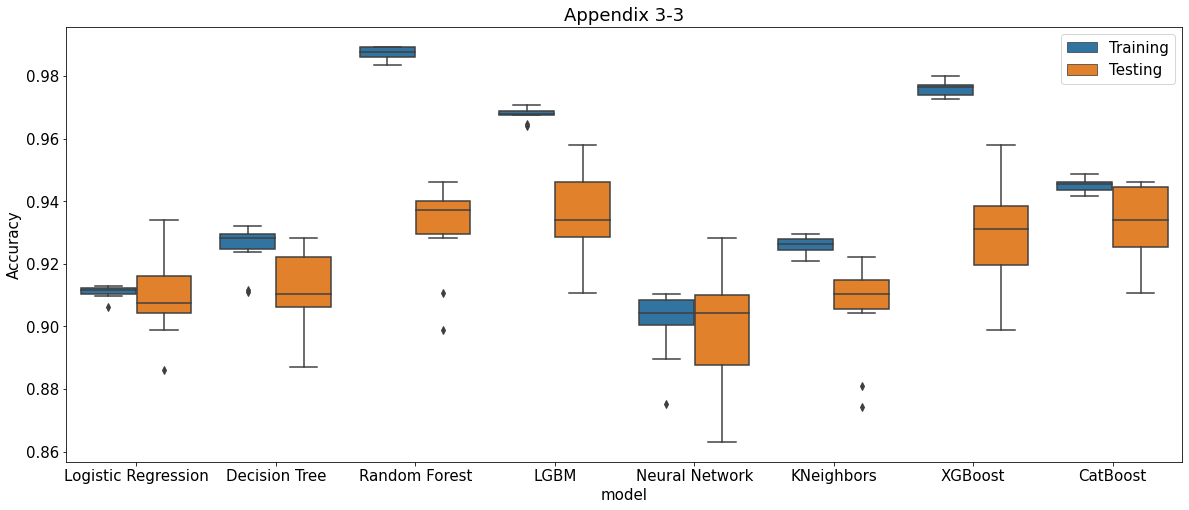

In [86]:
plt.figure(figsize = (20,8))
sns.boxplot(x='model',y='value',hue='variable', data = BS_compare)
plt.ylabel('Accuracy')
plt.legend(title = '')
plt.title ('Appendix 3-3')
plt.show()

<h2> 4.1 For Value (C) - With Created Variables </h2>
<h3> 4.1.1 Linear Regression </h3>

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import time
import itertools

In [88]:
value_score = pd.DataFrame(columns = ['r2_train', 'r2_test'])
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)

In [89]:
def cv(var,model):
    cv_score_train = []
    cv_score_test = []
    if model == 'Random Forest':
        model = RandomForestRegressor(random_state=9, n_estimators =100, max_depth = 100, 
                                      min_samples_split=10,min_samples_leaf=10)
    elif model == 'Linear':
        model = LinearRegression()
    elif model == 'LGBM':
        model = lgb.LGBMRegressor(random_state = 5, num_leaves=20,n_estimators=100, max_depth = 50)
    elif model == 'NN':
        model = MLPRegressor(random_state = 5,hidden_layer_sizes=(18,18,18), activation = 'relu', 
                             solver = 'adam', learning_rate= 'constant',
                          learning_rate_init = 0.01)
    elif model == 'KNeighbors':
        model = KNeighborsRegressor(n_neighbors=3)
    elif model == 'XGBoost':
        model = xgb.XGBRegressor(random_state = 5,max_depth=25, n_estimators=30)
    elif model == 'CatBoost':
        model = CatBoostRegressor(random_state = 5,verbose=0, max_depth=8, iterations=200, learning_rate = 0.1)
    for train_index, test_index in kfolds.split(X, y_value):
        X_train = X.iloc[train_index][list(var)]
        y_train = y_value.iloc[train_index]
        X_test = X.iloc[test_index][list(var)]
        y_test = y_value.iloc[test_index]
        # Train the model
        regression = model.fit(X_train, y_train)
        # Return the score
        # rsquared for train data
        TSS_train = ((y_train - y_train.mean())**2).sum()
        RSS_train = ((regression.predict(X_train) - y_train)**2).sum()
        r2_train = (TSS_train - RSS_train)/TSS_train
        # rsquared for test data
        TSS_test = ((y_test - y_test.mean())**2).sum()
        RSS_test = ((regression.predict(X_test) - y_test)**2).sum()
        r2_test = (TSS_test - RSS_test)/TSS_test
        cv_score_train.append(r2_train)
        cv_score_test.append(r2_test)
    return {"model": model, "r2_train": np.mean(cv_score_train),
            "r2_test": np.mean(cv_score_test), "variable": var}

def subset(var):
    X_train, X_test, y_train, y_test = train_test_split(X, y_value, test_size=0.2,random_state=2)
    X1 = sm.add_constant(X_train[list(var)])
    model = sm.OLS(y_train, X1)
    regression = model.fit()
    
    #rsquared for train data
    r2_train = regression.rsquared
    
    # rsquared for test data
    X2_test = sm.add_constant(X_test[list(var)])
    TSS = ((y_test - y_test.mean())**2).sum()
    RSS_test = ((regression.predict(X2_test) - y_test)**2).sum()
    r2_test = (TSS - RSS_test)/TSS

    return {"model": regression, "r2_train": r2_train, "r2_test": r2_test,'variable': var}

def getBest(k):
    results = []

    for combo in itertools.combinations(X.columns, k):
        results.append(subset(combo))
    
    # Wrap everything in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the smallest RSS
    best_model = models.loc[models['r2_test'].idxmax()]

    return best_model

In [90]:
models = pd.DataFrame(columns = ["model","r2_train", "r2_test",'variable'])
ct = time.time()
for i in range(1, X.shape[1]+1):
    models.loc[i] = getBest(i)

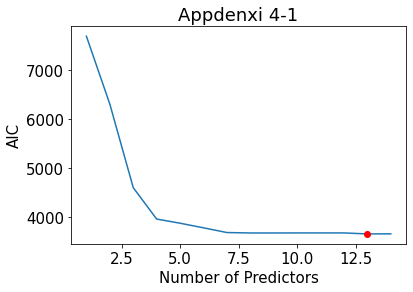

In [91]:
aic = models.apply(lambda row: row['model'].aic, axis = 1)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.ylabel('AIC')
plt.xlabel('Number of Predictors')
plt.title("Appdenxi 4-1")
plt.show()

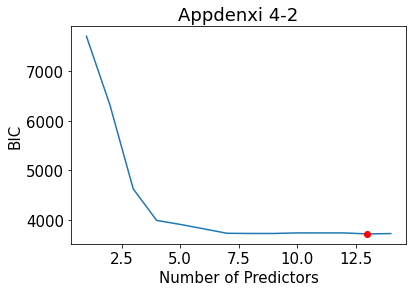

In [92]:
bic = models.apply(lambda row: row[0].bic, axis = 1)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.ylabel('BIC')
plt.xlabel('Number of Predictors')
plt.title("Appdenxi 4-2")
plt.show()

In [93]:
for i in range(1, X.shape[1]+1):
    models.loc[i] = cv(models.loc[i, 'variable'], 'Linear')
models['r2_test'] = models['r2_test'].astype("float")
value_score.loc['Linear Regression'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

In [94]:
def plot_score(models,title):
    models['r2_test'] = models['r2_test'].astype("float")
    plt.plot(models['r2_train'])
    plt.plot(models['r2_test'])
    plt.plot(models['r2_test'].idxmax(), models['r2_test'].max(),"or")
    plt.ylabel('R-Squared')
    plt.xlabel('Number of Predictors')
    plt.title("R-Squared for Training/Testing Data")
    plt.legend(['Train', 'Test'])
    plt.title(title)
    plt.show()

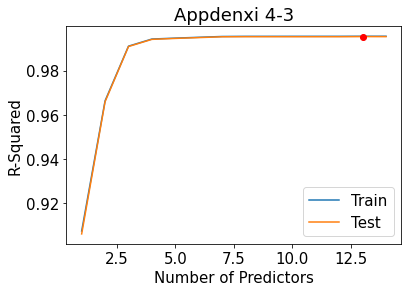

In [95]:
plot_score(models, 'Appdenxi 4-3')

<h3> 4.1.2 Random Forest Regression </h3>

In [96]:
def subset(var, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y_value, test_size=0.2,random_state=2)
    X1 = X_train[list(var)]
    if model == 'Random Forest':
        model = RandomForestRegressor(random_state=9, n_estimators =100, max_depth = 100, 
                                      min_samples_split=10,min_samples_leaf=10)
    elif model == 'LGBM':
        model = lgb.LGBMRegressor(random_state = 5, num_leaves=20,n_estimators=100, max_depth = 50)
    elif model == 'NN':
        model = MLPRegressor(random_state = 5,hidden_layer_sizes=(18,18,18), activation = 'relu', 
                             solver = 'adam', learning_rate= 'constant',
                          learning_rate_init = 0.01, max_iter= 300)
    elif model == 'KNeighbors':
        model = KNeighborsRegressor(n_neighbors=3)
    elif model == 'XGBoost':
        model = xgb.XGBRegressor(random_state = 5,max_depth=25, n_estimators=30)
    elif model == 'CatBoost':
        model = CatBoostRegressor(random_state = 5,verbose=0, max_depth=8, iterations=200, learning_rate = 0.1)
    regression = model.fit(X1, y_train)
    X2_test = X_test[list(var)]
    # rsquared for train data
    TSS = ((y_train - y_train.mean())**2).sum()
    RSS_train = ((regression.predict(X1) - y_train)**2).sum()
    r2_train = (TSS - RSS_train)/TSS
    # rsquared adj for test data
    TSS = ((y_test - y_test.mean())**2).sum()
    RSS_test = ((regression.predict(X2_test) - y_test)**2).sum()
    r2_test = (TSS - RSS_test)/TSS
    return {"model": regression, "r2_train": r2_train, "r2_test": r2_test,"variable": var}

def forward(predictors,model):
    ct = time.time()
    results = []
    remaining = X.columns.drop(predictors)
    for pred in remaining:
        results.append(subset(predictors + [pred],model))
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    best_model = models.loc[models['r2_test'].idxmax()]
    return best_model

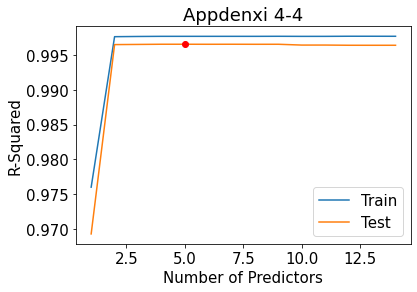

In [97]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'Random Forest')
    models.loc[i] = cv(models.loc[i, 'variable'], 'Random Forest')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-4')
value_score.loc['Random Forest'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

<h3> 4.1.3 LGBM Regression </h3>

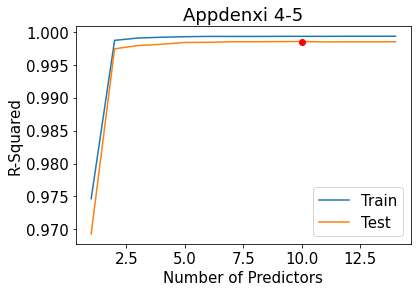

In [98]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'LGBM')
    models.loc[i] = cv(models.loc[i, 'variable'], 'LGBM')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-5')
value_score.loc['LGBM'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

<h3> 4.1.4 Neural Network Regression </h3>

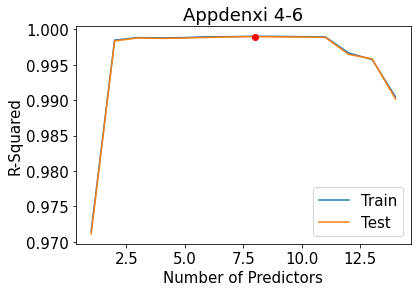

In [99]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'NN')
    models.loc[i] = cv(models.loc[i, 'variable'], 'NN')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-6')
value_score.loc['Neural Network'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

<h3> 4.1.5 KNeighbors Regression </h3>

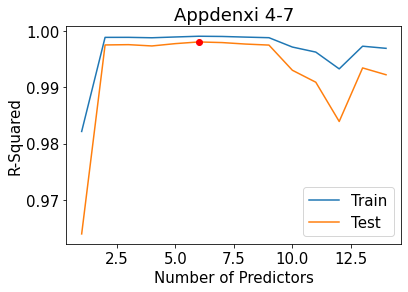

In [100]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'KNeighbors')
    models.loc[i] = cv(models.loc[i, 'variable'], 'KNeighbors')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-7')
value_score.loc['KNeighbors'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

<h3> 4.1.6 XGBoost Regression </h3>

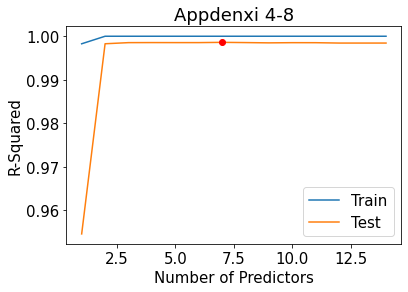

In [101]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'XGBoost')
    models.loc[i] = cv(models.loc[i, 'variable'], 'XGBoost')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-8')
value_score.loc['XGBoost'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

<h3> 4.1.7 CatBoost Regression </h3>

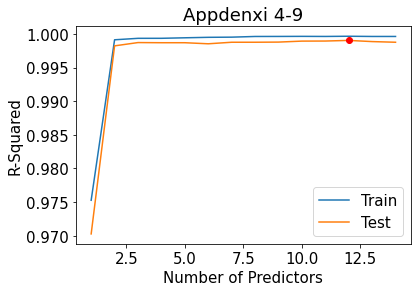

In [102]:
forward_num = X.shape[1]
models = pd.DataFrame(columns = ["model",'r2_train', "r2_test","variable"])
predictors = []
for i in range(1, forward_num + 1):
    models.loc[i] = forward(predictors, model = 'CatBoost')
    models.loc[i] = cv(models.loc[i, 'variable'], 'CatBoost')
    predictors = models.loc[i]['variable']
plot_score(models,'Appdenxi 4-9')
value_score.loc['CatBoost'] = models.loc[models['r2_test'].idxmax(),['r2_train', 'r2_test']]

In [103]:
value_score

,r2_train,r2_test
Linear Regression,0.995506,0.995352
Random Forest,0.997706,0.996568
LGBM,0.999313,0.998528
Neural Network,0.999029,0.99898
KNeighbors,0.99906,0.998048
XGBoost,0.999999,0.998595
CatBoost,0.99967,0.99905


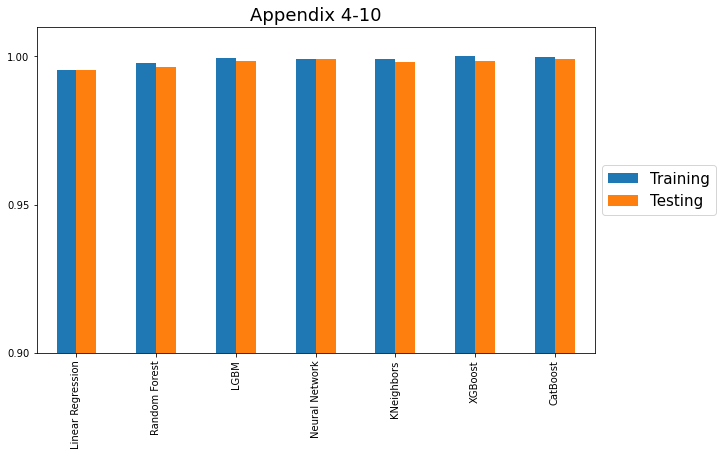

In [104]:
value_score.plot(kind = 'bar', figsize = (10,6), fontsize = 10)
plt.legend(['Training', 'Testing'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.9, 1.01)
plt.yticks([0.9, 0.95,1.0])
plt.title ('Appendix 4-10')
plt.show()

# 4.2 For BS 
<h2> 4.2.1 Logistic Regression </h2>

In [105]:
kfolds = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
BS_score = BS_score = pd.DataFrame(columns = ['score_train', 'score_test'])

In [106]:
def cv(var,model_name):
    cv_classification_score_train = []
    cv_classification_score_test = []
    if model_name == 'Logistics':
        model = LogisticRegression(penalty='none', max_iter=10000)        
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=3, n_estimators =100, max_depth = 100, 
                                       min_samples_split= 2, min_samples_leaf=2)
    elif model_name == 'LGBM':
        model = lgb.LGBMClassifier(num_leaves=25,n_estimators=30, max_depth = 30)
    elif model_name == 'NN':
        model = MLPClassifier(random_state = 5, hidden_layer_sizes=(15,15,15,15,15), 
                              activation = 'relu', solver = 'adam', learning_rate= 'adaptive',
                          learning_rate_init = 0.01)
    elif model_name == 'KNeighbors':
        model = KNeighborsClassifier(n_neighbors = 8)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(random_state = 5, max_depth=10, n_estimators=5)
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(random_state = 5, verbose=0, max_depth=5, iterations=100, learning_rate = 0.1)    
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=3, max_depth=20,min_samples_split=20,min_samples_leaf=20)
        
    for train_index, test_index in kfolds.split(X, y_BS):
        X1 = X.iloc[train_index][var]
        y_train = y_BS.iloc[train_index]
        X_test = X.iloc[test_index][var]
        y_test = y_BS.iloc[test_index]
        model = model.fit(X1,y_train)
        cv_classification_score_train.append(model.score(X1, y_train))
        cv_classification_score_test.append(model.score(X_test[var], y_test))

    return {"model": model, "score_train": np.mean(cv_classification_score_train), 
            "score_test": np.mean(cv_classification_score_test), "variable": var}

def subset(var, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X[var], y_BS, test_size=0.2,random_state=4)
    if model_name == 'Logistics':
        model = LogisticRegression(penalty='none', max_iter=10000)        
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=3, n_estimators =100, max_depth = 100, 
                                       min_samples_split= 2, min_samples_leaf=2)
    elif model_name == 'LGBM':
        model = lgb.LGBMClassifier(num_leaves=25,n_estimators=30, max_depth = 30)
    elif model_name == 'NN':
        model = MLPClassifier(random_state = 5, hidden_layer_sizes=(15,15,15,15,15), 
                              activation = 'relu', solver = 'adam', learning_rate= 'adaptive',
                          learning_rate_init = 0.01)
    elif model_name == 'KNeighbors':
        model = KNeighborsClassifier(n_neighbors = 8)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(random_state = 5, max_depth=10, n_estimators=5)
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(random_state = 5, verbose=0, max_depth=5, iterations=100, learning_rate = 0.1)    
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=3, max_depth=20,min_samples_split=20,min_samples_leaf=20)

    model = model.fit(X_train, y_train)

    # Return the score
    # accuracy score for train data
    score_train = accuracy_score(model.predict(X_train), y_train)

    # accuracy score for test data
    score_test = accuracy_score(model.predict(X_test), y_test)

    return {"model": regression, "score_train": score_train, "score_test": score_test,'variable': var}

def forward(predictor, model_name):
    results = []
    remaining = X.columns.drop(predictors)
    for pred in remaining:
        results.append(subset(predictors + [pred], model_name))
    
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    best_model = models.loc[models['score_test'].idxmax()]

    return best_model

In [107]:
forward_num = X.shape[1]
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors,'Logistics')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'Logistics')

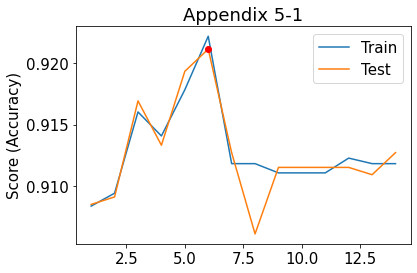

In [108]:
def plot_score(models2,title):
    models2['score_test'] = models2['score_test'].astype("float")
    plt.plot(models2['score_train'])
    plt.plot(models2['score_test'])
    plt.plot(models2['score_test'].idxmax(), models2['score_test'].max(),"or")
    plt.ylabel('Score (Accuracy)')
    plt.legend(['Train', 'Test'])
    plt.title(title)
    plt.show()
plot_score(models2, 'Appendix 5-1')
BS_score.loc['Logistic Regression'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 3.2.2 Decision Tree </h3>

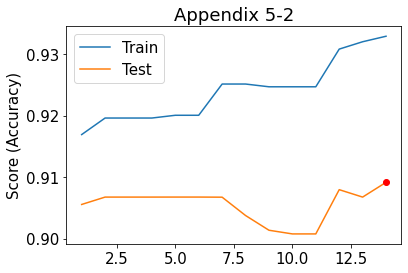

In [109]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'Decision Tree')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'Decision Tree')
plot_score(models2, 'Appendix 5-2')
BS_score.loc['Decision Tree'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.3 Random Forest </h3>

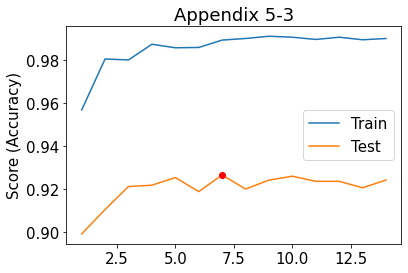

In [110]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'Random Forest')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'Random Forest')
plot_score(models2,'Appendix 5-3')
BS_score.loc['Random Forest'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.4 LGBM Classification </h3>

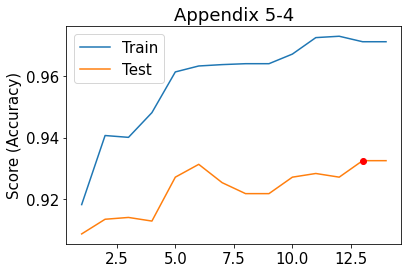

In [111]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'LGBM')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'LGBM')
plot_score(models2,'Appendix 5-4')
BS_score.loc['LGBM'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.5 Neural Network Classification </h3>

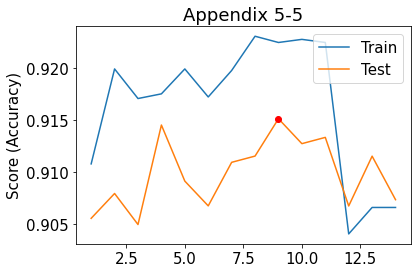

In [112]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'NN')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'NN')
plot_score(models2,'Appendix 5-5')
BS_score.loc['Neural Network'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.6 KNeighbors Classification </h3>

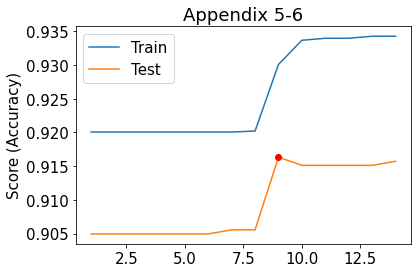

In [113]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'KNeighbors')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'KNeighbors')
plot_score(models2,'Appendix 5-6')
BS_score.loc['KNeighbors'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.7 XGBoost Classification </h3>

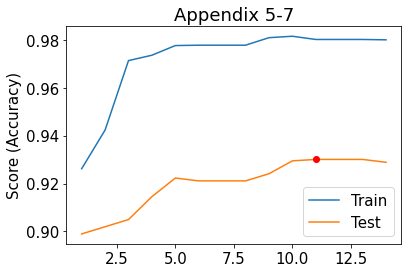

In [114]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'XGBoost')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'XGBoost')
plot_score(models2,'Appendix 5-7')
BS_score.loc['XGBoost'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

<h3> 4.2.8 CatBoost Classification </h3>

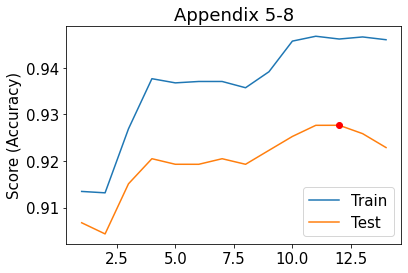

In [115]:
models2 = pd.DataFrame(columns = ['model', 'score_train', 'score_test', 'variable'])
predictors = []
for i in range(1, forward_num + 1):
    models2.loc[i] = forward(predictors, 'CatBoost')
    predictors = models2.loc[i]['variable']
    models2.loc[i] = cv(models2.loc[i, 'variable'], 'CatBoost')
plot_score(models2,'Appendix 5-8')
BS_score.loc['CatBoost'] = models2.loc[models2['score_test'].idxmax(),['score_train', 'score_test']]

In [116]:
BS_score

,score_train,score_test
Logistic Regression,0.922146,0.921108
Decision Tree,0.932905,0.909148
Random Forest,0.98939,0.926485
LGBM,0.971309,0.932462
Neural Network,0.922445,0.915124
KNeighbors,0.930067,0.916329
XGBoost,0.980124,0.930067
CatBoost,0.946204,0.927684


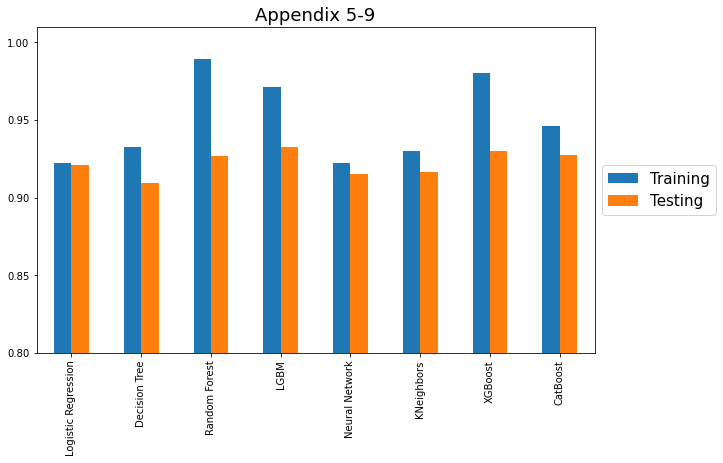

In [117]:
BS_score.plot(kind = 'bar', figsize = (10,6), fontsize = 10)
plt.legend(['Training', 'Testing'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.8, 1.01)
plt.yticks([0.8, 0.85, 0.9, 0.95,1.0])
plt.title ('Appendix 5-9')
plt.show()

<h1> 5. Predict the Option Value and BS with Selected Models</h1>

In [118]:
data_test = pd.read_csv('option_test_wolabel.csv')

In [119]:
original_var = ['S', 'K', 'tau', 'r']
model = xgb.XGBRegressor(random_state = 5,max_depth=25, n_estimators=30)
model = model.fit(X[original_var], y_value)
test_value = model.predict(data_test)

model = CatBoostClassifier(random_state = 5, verbose=0, max_depth=5, iterations=100, learning_rate = 0.1)
model = model.fit(X[original_var], y_BS)
test_BS = model.predict(data_test)
pd.DataFrame({'Value': test_value,'BS':test_BS}).to_csv('group_11_prediction.csv')